In [3]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
print("Imports Successful")

Imports Successful


In [4]:
def CloningCoeffs(theta0, theta1):
    theta2 = np.arctan(np.tan(theta0) * np.tan(theta1))
    mu = np.cos(theta0) * np.cos(theta1) * np.cos(theta2) + np.sin(theta0) * np.sin(theta1) * np.sin(theta2)
    xi = np.sin(theta0) * np.cos(theta1) * np.cos(theta2) - np.cos(theta0) * np.sin(theta1) * np.sin(theta2)
    nu = np.cos(theta0) * np.sin(theta1) * np.sin(theta2) + np.sin(theta0) * np.cos(theta1) * np.cos(theta2)
    return mu, xi, nu

In [5]:
def fidelities(theta0, theta1):
    mu, xi, nu = CloningCoeffs(theta0, theta1)
    etaA = 2 * mu * nu
    etaB = 2 * mu * xi
    fidA = (1 + etaA)/2
    fidB = (1 + etaB)/2
    return fidA, fidB

In [15]:
theta1s = np.linspace(np.pi/8, 3*np.pi/8,100)
theta2s = theta1s
Theta1, Theta2 = np.meshgrid(theta1s, theta2s)
fidA, fidB = fidelities(Theta1, Theta2)

/tmp/ipykernel_698801/2941413879.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


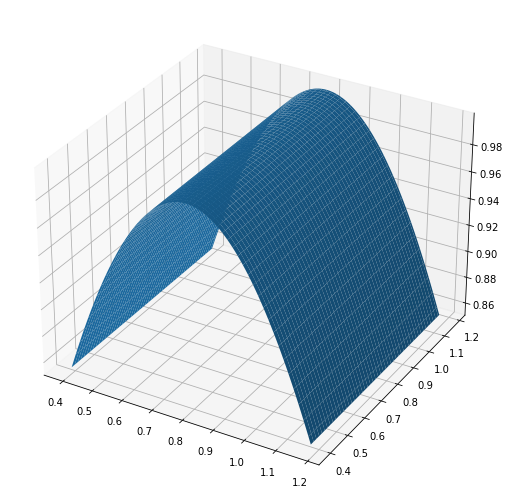

In [16]:
fig = plt.figure(figsize = (9,9))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Theta1, Theta2, fidA)
plt.show()

/tmp/ipykernel_698801/835816197.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


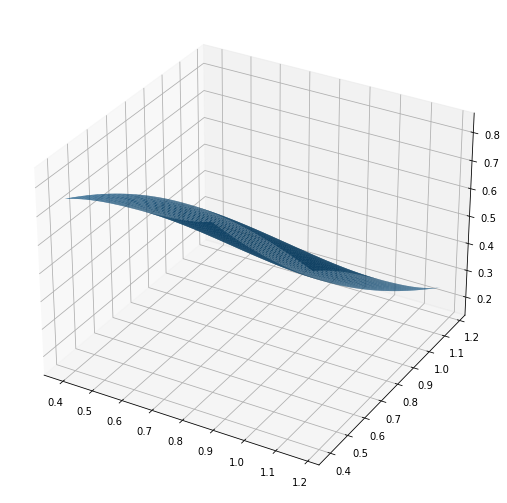

In [17]:
fig = plt.figure(figsize = (9,9))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Theta1, Theta2, fidB)
plt.show()

### Updated Fidelity Calculations
In recently updated notes we showed that the fidelity of the $A$-clone is given by
$$
F_{A}(\theta_{1}, \theta_{2}) = \frac{1}{2}(1 + \eta_{A}(\theta_{1}, \theta_{2})) \qquad \text{where} \qquad \eta_{A}(\theta_{1}, \theta_{2}) = \sin(2\theta_{1}).
$$
That is, $F_{A}(\theta_{1}, \theta_{2}) = \frac{1}{2}(1 + \sin(2 \theta_{1}))$. It is siginificant that the fidelity of the $A$-clone does not depend on the value of $\theta_{2}$. This means that when Eve is preparing her probe to clone the qubit in transit from Alice to Bob, she can select $\theta_{1}$ so that Bob gets a reasonably good clone of the qubit and can then optimize her own results by selecting an appropriate value of $\theta_{2}$. 

### Optimizing the Fidelity of the $B$-Clone
We focus on the problem of optimizing $\eta_{B}$. Calculations in an updated set of notes show that $\eta_{B}(\theta_{1}, \theta_{2}) = \sin(2\theta_{1}) \cos(2\theta_{2})$. One might hope that for a given value of $\theta_{1}$ (which determines $\eta_{A}$ and thereby fidelity of the $A$-clone) one can simply take $\theta_{2} = 0$ to optimize the value of $\eta_{B}$ (and thus of the $B$-clone). However, there are constraints in the problem that make this problem more complicated. For convenience we return to the notation of Rezakhani et al and write the problem in terms of $\mu, \nu$, and $\xi$.

The optimization problem that we are concerned with is the problem of maximizing
$$
\eta_{B} = 2 \mu \xi \qquad \text{subject to} \qquad 2 \mu \nu = \eta_{A}, \quad \mu^{2} + \nu^{2} + \xi^{2} = 1.
$$
We view this as a constrained optimization problem and apply the technique of Lagrange multipliers. Details are forthcoming in the notes. The key result of these calculations is the that the optimal value of $\eta_{B}$ satisfies
$$
\eta_{A}^{2} + \eta_{B}^{2} = 1.
$$
From this it follows that the optimal choice of $\theta_{2}$ is given by
$$
\theta_{2} = \frac{1}{2} \arccos \Big ( \cot(2 \theta_{1}) \Big ).
$$
Here we restrict $\theta_{1} \in [\pi/8, 3\pi/8]$.

In [37]:
def theta_maker(theta1):
    if (theta1 == np.pi/8) or (theta1 == 3*np.pi/8):
        theta2 = 0
        theta3 = 0
        return np.array([theta1, theta2, theta3])
    
    
    etaA = np.sin(2 * theta1)
    theta2 = 0.5 * np.arccos(np.cos(2*theta1)/np.sin(2*theta1))
    theta3 = np.arctan(np.tan(theta1) * np.tan(theta2))
    theta = np.array([theta1, theta2, theta3])
    return theta

In [39]:
theta_maker(np.pi/8)
theta_maker(3*np.pi/8)

array([1.17809725, 0.        , 0.        ])

In [40]:
# this is a function that implements the cloning that Eve uses
def EveClones(qc, theta1):
    # determine optimizing angles
    theta = theta_maker(theta1)
    
    # prepare to clone 
    qc.u(2*theta[0], 0, 0, 1)
    qc.cx(1,2)
    qc.u(2*theta[1], 0, 0, 2)
    qc.cx(2,1)
    qc.u(2*theta[2], 0, 0, 1)
    
    # execute the cloning component with the input qubit (the 0 qubit here)
    qc.cx(0,1)
    qc.cx(0,2)
    qc.cx(1,0)
    qc.cx(2,0)
    
    qc.barrier()
    
    return qc

In [41]:
# function that runs 10000 shots and records the probability that Bob (resp. Eve) receives the correct measurement. In this case Alice is sending a qubit in the state |-> state so we expect Bob to measure a 1.
def MeasurementStats(theta1):
    # returns the probability that Bob returns a 1 (which is the correct measurement result in this case). We use 10000 shots here
    qc = QuantumCircuit(3,2)
    qc.x(0)
    qc.h(0)
    qc.barrier()

    
    

    EveClones(qc,theta1)

    qc.h(0)
    qc.measure(0,0)
    qc.barrier()

    qc.h(1)
    qc.measure(1,1)

    #qc5.draw()

    shots = 10000 # number of samples used for statistics
    sim = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend = sim, shots = shots)
    
    out00 = job.result().get_counts().get("00")
    out01 = job.result().get_counts().get("01")
    out10 = job.result().get_counts().get("10")
    out11 = job.result().get_counts().get("11")
    
    if out00 == None:
        out00 = 0
    if out01 == None:
        out01 = 0
    if out10 == None:
        out10 = 0
    if out11 == None:
        out11 = 0
    
    BobProb = (out10 + out11)/shots
    EveProb = (out01 + out11)/shots
    return BobProb, EveProb

In [44]:
Bob1, Eve1 = MeasurementStats(np.pi/8)
print(Bob1, Eve1)
print(Bob1**2 + Eve1**2)

0.8553 0.5001
0.9816380999999998


In [45]:
Bob2, Eve2 = MeasurementStats(3*np.pi/8)
print(Bob2, Eve2)
print(Bob2**2 + Eve2**2)

0.8485 0.4996
0.96955241


In [46]:
Bob3, Eve3 = MeasurementStats(np.pi/4)
print(Bob3, Eve3)
print(Bob3**2 + Eve3**2)

0.4956 1.0
1.24561936


In [54]:
theta = theta_maker(np.pi/8)
Bobfid1, Evefid1 = fidelities(theta[0], theta[1])
print(Bobfid1)

0.8535533905932737


In [55]:
theta = theta_maker(3*np.pi/8)
Bobfid2, Evefid2 = fidelities(theta[0], theta[1])
print(Bobfid2)

0.8535533905932738


In [56]:
theta = theta_maker(np.pi/4)
Bobfid3, Evefid3 = fidelities(theta[0], theta[1])
print(Bobfid3)

0.9999999999999999


In [57]:
theta = theta_maker(3*np.pi/16)
Bobfid4, Evefid4 = fidelities(theta[0], theta[1])
print(Bobfid4)

0.9619397662556433


In [58]:
Bob4, Eve4 = MeasurementStats(3*np.pi/16)
print(Bob4, Eve4)

0.6899 0.9558


I'm not sure what's happened here. It seems like the clones have been swapped. I expect the fidelities to be the other way around.

In [59]:
Bob5, Eve5 = MeasurementStats(5*np.pi/16)
print(Bob5, Eve5)
theta = theta_maker(5*np.pi/16)
Bobfid5, Evefid5 = fidelities(theta[0], theta[1])
print(Bobfid5)

0.3056 0.9531
0.9619397662556434


In [60]:
print(Bob5**2 + Eve5**2)

1.0017909699999998
